In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
import pickle
import json

In [2]:
# Load the dataset
df = pd.read_csv('diabetes (1).csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


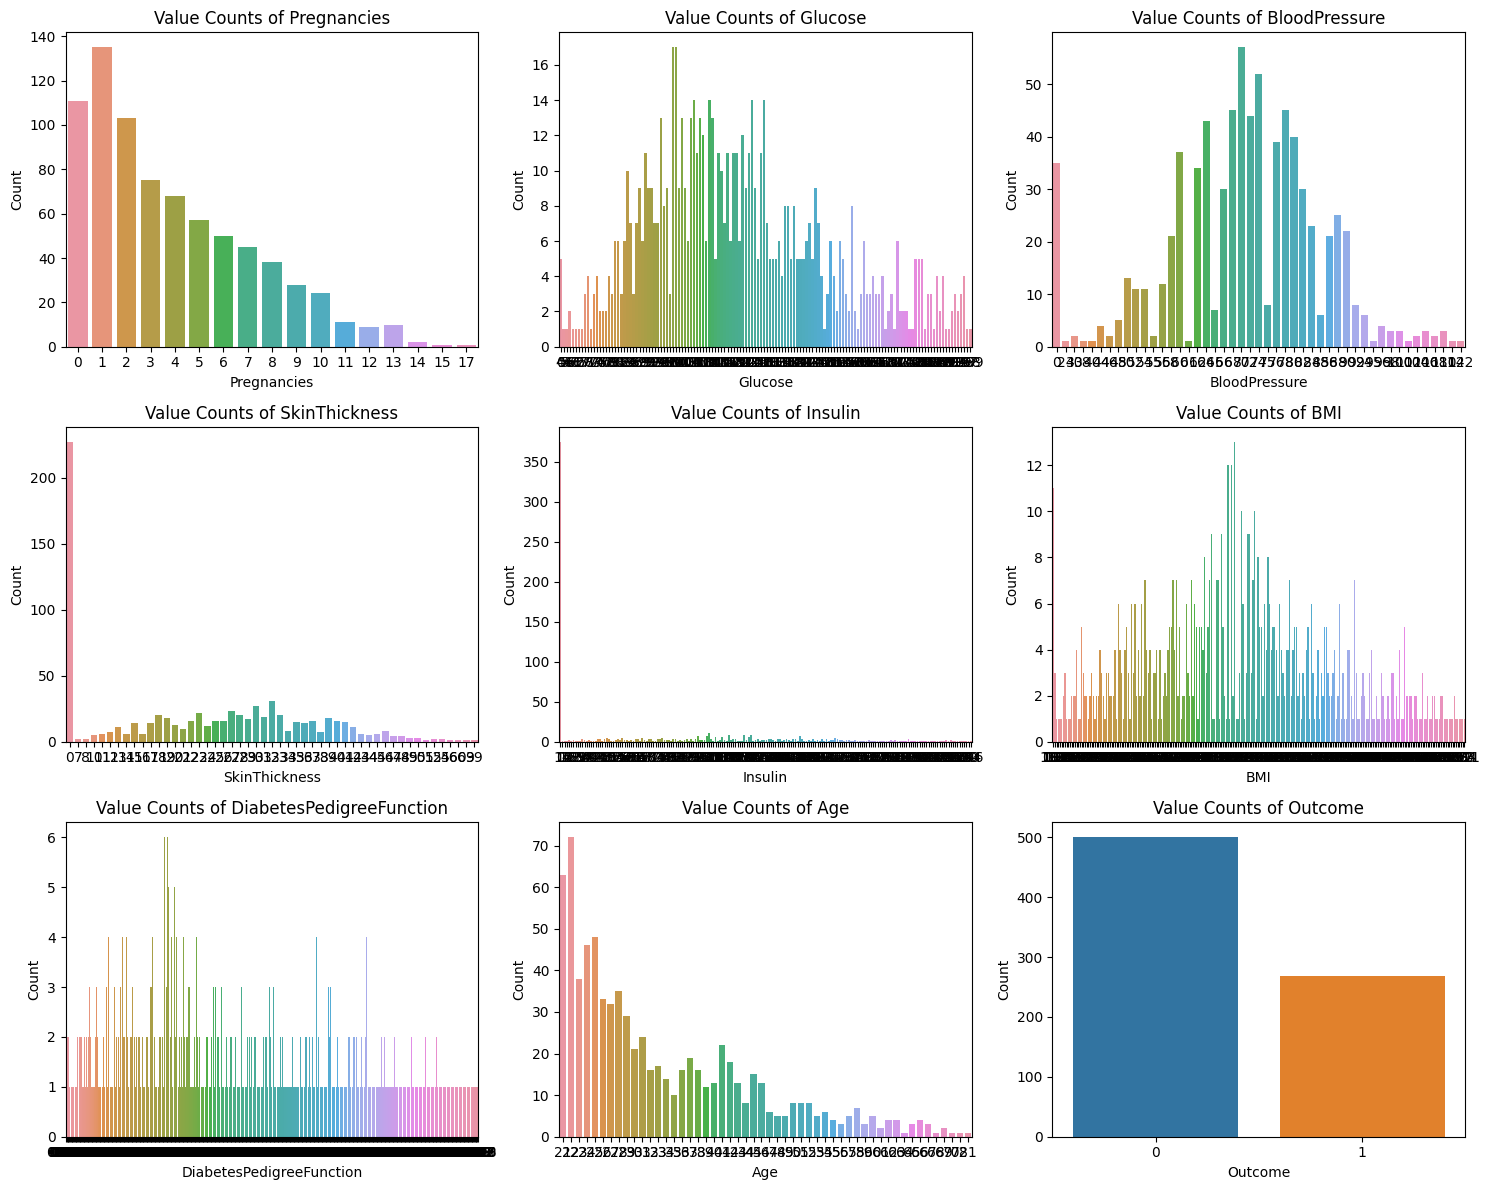

In [5]:
# Plotting
columns_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Plot count plots for each column
for i, ax in enumerate(axes.flatten()):
    if i < len(columns_to_plot):
        sns.countplot(x=df[columns_to_plot[i]], ax=ax)
        ax.set_title(f'Value Counts of {columns_to_plot[i]}')
        ax.set_xlabel(columns_to_plot[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

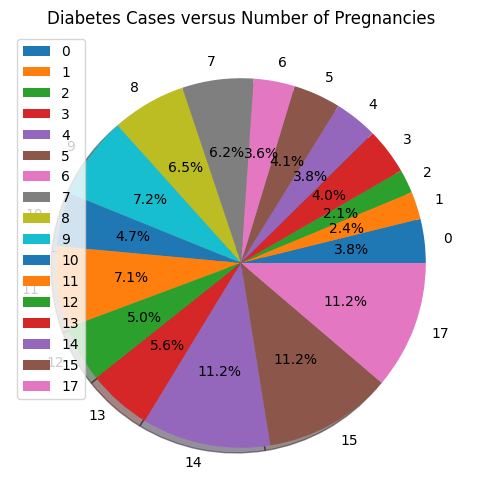

In [6]:
pregnant_diabetes = df.groupby(['Pregnancies'])['Outcome'].mean()
plt.figure(figsize=(8, 6))
plt.pie(pregnant_diabetes, labels=pregnant_diabetes.index, autopct='%1.1f%%', shadow=True)
plt.title('Diabetes Cases versus Number of Pregnancies')
plt.legend()
plt.show()

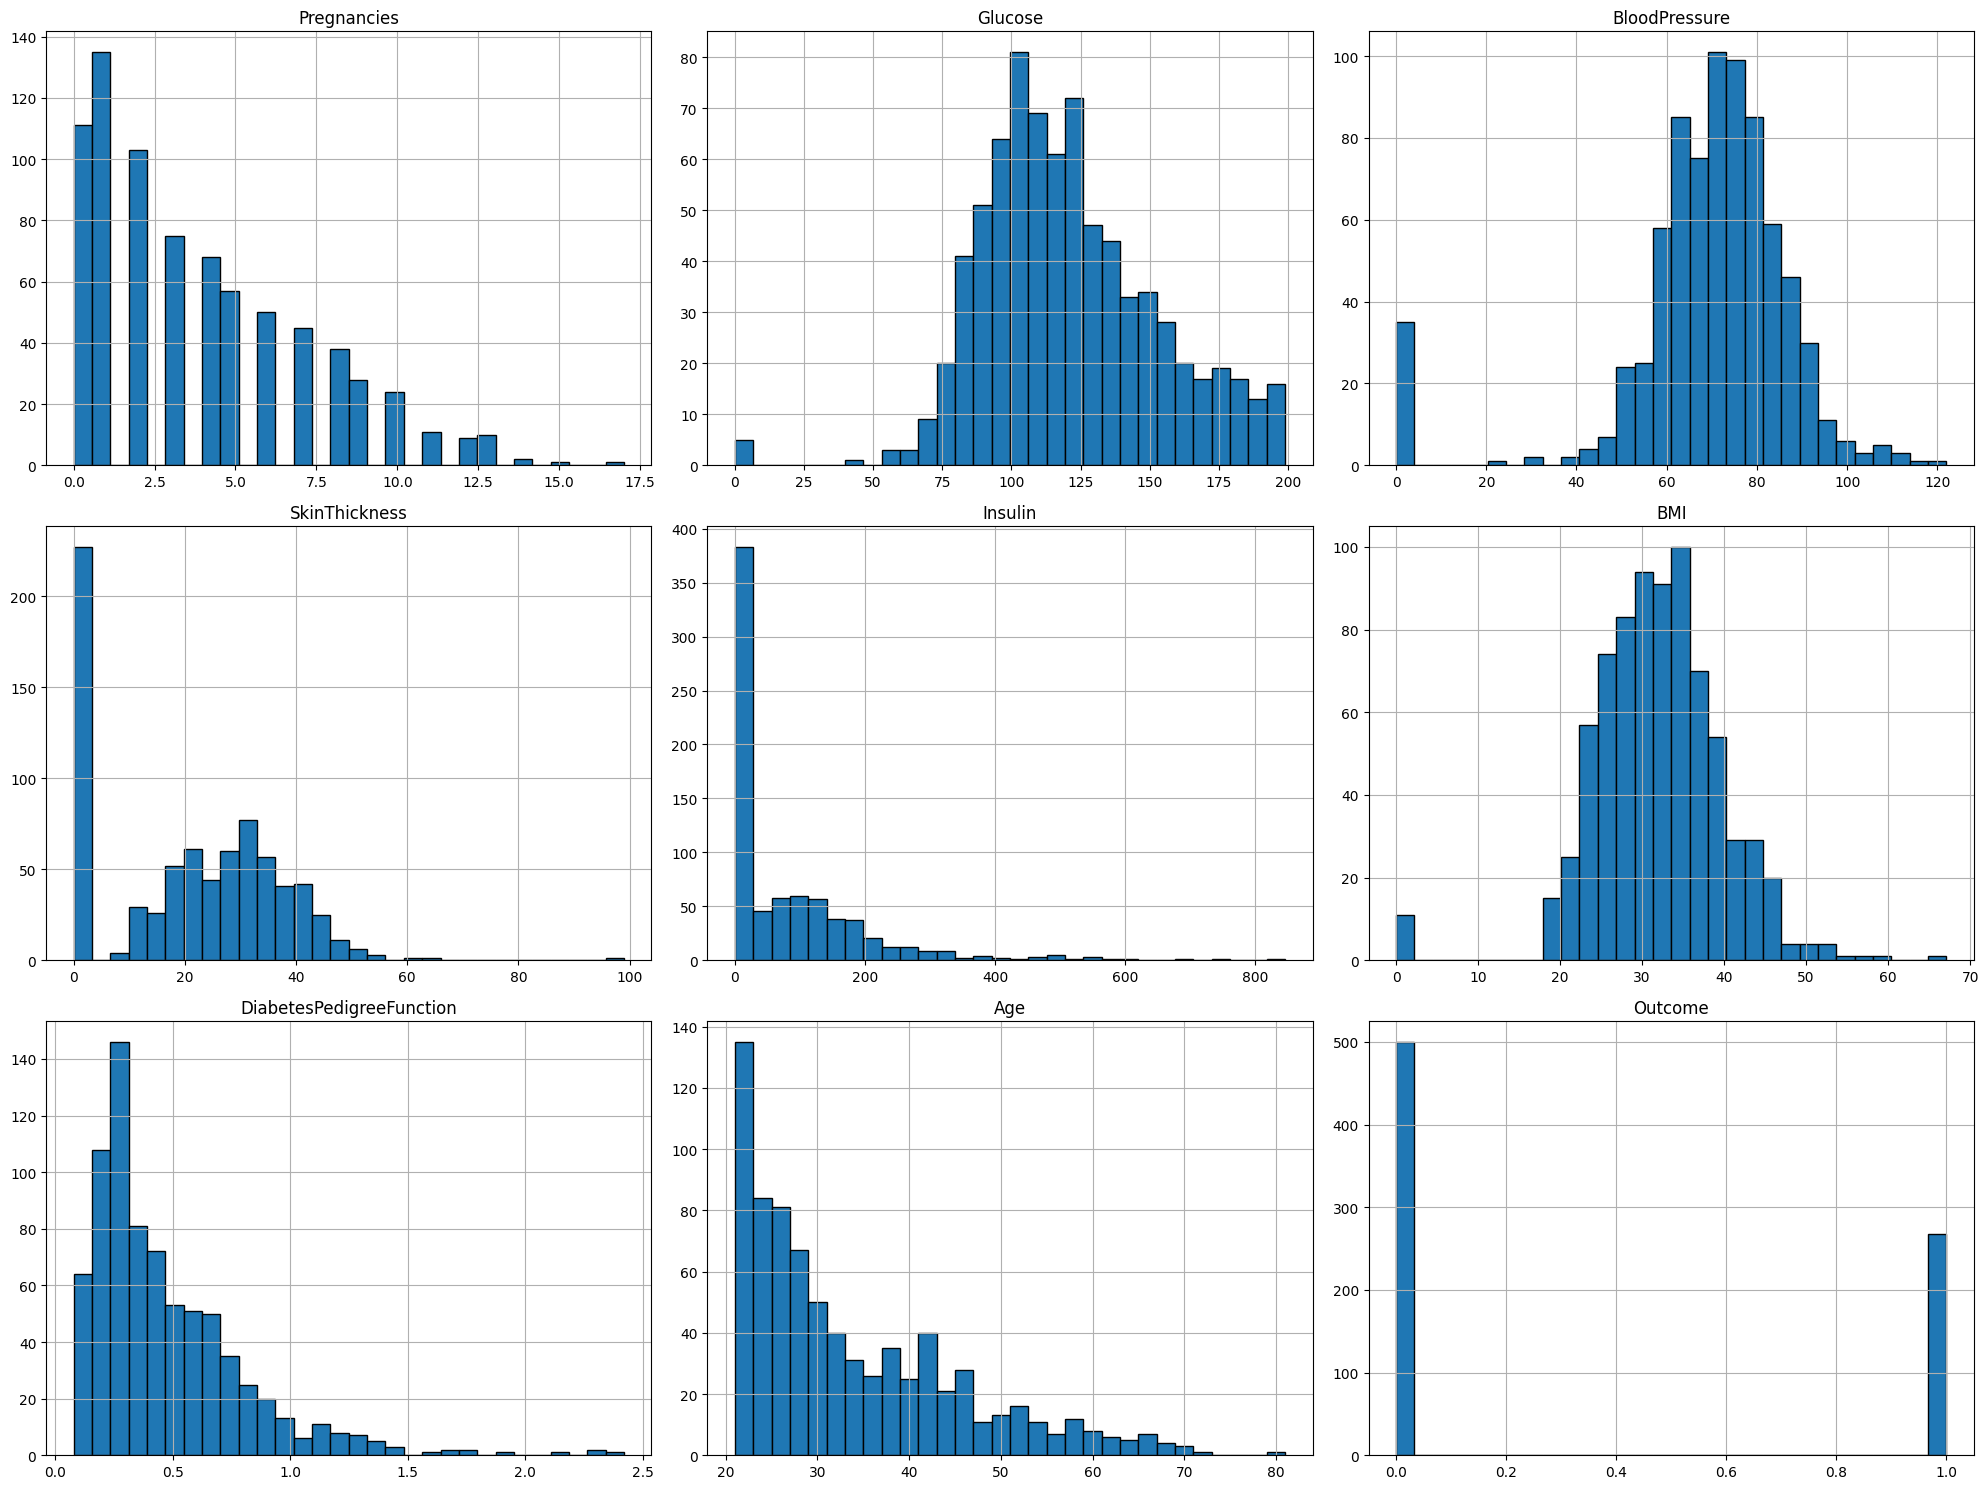

In [7]:
# Histograms for each feature
df.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.tight_layout()
plt.show()


In [8]:
# Check for NA's
print(df.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
# Check for Outliers and remove them
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_outlier = Q1 - (1.5 * IQR)
    upper_outlier = Q3 + (1.5 * IQR)
    return df[(df[column] > lower_outlier) & (df[column] < upper_outlier)]

df = remove_outliers(df, 'Insulin')
df = remove_outliers(df, 'Pregnancies')
df = remove_outliers(df, 'Glucose')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,3.768794,118.079433,68.855319,19.648227,59.944681,31.755035,0.464583,32.995745,0.321986
std,3.300162,27.921144,19.922764,15.729548,75.152807,7.979454,0.320708,11.582031,0.467569
min,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.100000,0.243000,24.000000,0.000000
50%,3.000000,114.000000,72.000000,22.000000,0.000000,32.000000,0.365000,29.000000,0.000000
75%,6.000000,136.000000,80.000000,32.000000,110.000000,36.100000,0.613000,40.000000,1.000000
max,13.000000,191.000000,122.000000,63.000000,285.000000,67.100000,2.420000,81.000000,1.000000


In [11]:
# Predictions and Fitting Models
x = df.drop(['Outcome', 'SkinThickness', 'Insulin'], axis='columns')
y = df['Outcome']

In [12]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [13]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10]
        }
    },
    'decision_tree': {
        'model': tree.DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse'],
            'splitter': ['best', 'random']
        }
    }
}

# Perform grid search for each model
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_scaled, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Create a DataFrame with the results
results_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(results_df)

                 model  best_score  \
0                  svm    0.781560   
1        random_forest    0.757447   
2  logistic_regression    0.767376   
3        decision_tree   -0.332145   

                                         best_params  
0                          {'C': 1, 'kernel': 'rbf'}  
1                               {'n_estimators': 10}  
2                                           {'C': 5}  
3  {'criterion': 'friedman_mse', 'splitter': 'best'}  


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", 

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
model = SVC(C=1, kernel='rbf')
model.fit(x_train, y_train)

SVC(C=1)

In [17]:
def predict_diabeties(Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, Age):
    x = np.array([[Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, Age]])
    x_scaled = scaler.transform(x)
    return model.predict(x_scaled)[0]

In [18]:
print(predict_diabeties(6,148,72,33.6,0.627,50))

1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
print(predict_diabeties(5,116,74,25.6,0.201,30))

0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
# Save the model
with open('model-pickle', 'wb') as f:
    pickle.dump(model, f)

with open('scaler-pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Save the columns
columns = {
    'data_columns': [col.lower() for col in x.columns]
}
with open('model-json', 'w') as f:
    f.write(json.dumps(columns))